In [1]:
from wiki_scraper.word_counter import *
from wiki_scraper.frequency_analysis import *

In [2]:
def lang_confidence_score(word_counts, language_words_with_frequency):
    total_counts = sum(word_counts.values())
    total_lang = sum(language_words_with_frequency.values())

    if total_counts == 0 or total_lang == 0:
        return 0.0

    score = 0.0

    for word, count in word_counts.items():
        if word in language_words_with_frequency:
            p_text = count / total_counts
            p_lang = language_words_with_frequency[word] / total_lang
            score += p_text * p_lang

    return score

oblicza popularność danego słowa z tekstu wzorem: p_tekst(w)= count(w)/ ∑_s count(s) (czyli popularność słowa przez sumę popularności wszystkich słów)
analogicznie oblicza popularność p_freq słowa z wordfreq.

Wynik to ∑ p_tekst(w)*p_freq(w)

In [3]:
def k_split(freqs, k):
    items = list(freqs.items())[:k]
    return dict(items)

Zostawia tylko k najpopularniekszych słów w freqs

In [4]:
freqs_en_full = load_language_frequencies("en", top_n=2000)
freqs_pl_full = load_language_frequencies("pl", top_n=2000)
freqs_it_full = load_language_frequencies("it", top_n=2000)

len(freqs_en_full), len(freqs_pl_full), len(freqs_it_full)

(2000, 2000, 2000)

2000 najpopularniejszych słów z kazdego języka

In [5]:
wiki_good_en_path = "data/word-counts-good.json"
wiki_bad_en_path = "data/word-counts-bad.json"

with open(wiki_good_en_path, "r", encoding="utf-8") as f:
    wiki_good_en_counts = json.load(f)

with open(wiki_bad_en_path, "r", encoding="utf-8") as f:
    wiki_bad_en_counts = json.load(f)

print("wiki_good_en: słów unikalnych =", len(wiki_good_en_counts),
      ", wszystkich wystąpień =", sum(wiki_bad_en_counts.values()))
print("wiki_bad_en: słów unikalnych  =", len(wiki_bad_en_counts),
      ", wszystkich wystąpień =", sum(wiki_good_en_counts.values()))

wiki_good_en: słów unikalnych = 1721 , wszystkich wystąpień = 469
wiki_bad_en: słów unikalnych  = 272 , wszystkich wystąpień = 8820


In [6]:
external_en_path = "data/erdos-en.txt"
external_pl_path = "data/pierogi-pl.txt"
external_it_path = "data/padrino-it.txt"

with open(external_en_path, "r", encoding="utf-8") as f:
    external_en_text = f.read()

with open(external_pl_path, "r", encoding="utf-8") as f:
    external_pl_text = f.read()

with open(external_it_path, "r", encoding="utf-8") as f:
    external_it_text = f.read()

external_en_counts = count_words(external_en_text)
external_pl_counts = count_words(external_pl_text)
external_it_counts = count_words(external_it_text)

print("external_en: unikalnych słów =", len(external_en_counts),
      ", łącznie =", sum(external_en_counts.values()))
print("external_pl: unikalnych słów =", len(external_pl_counts),
      ", łącznie =", sum(external_pl_counts.values()))
print("external_it: unikalnych słów =", len(external_it_counts),
      ", łącznie =", sum(external_it_counts.values()))

external_en: unikalnych słów = 1160 , łącznie = 3470
external_pl: unikalnych słów = 1315 , łącznie = 3877
external_it: unikalnych słów = 1797 , łącznie = 5952


In [7]:
languages = {
    "en": freqs_en_full,
    "pl": freqs_pl_full,
    "it": freqs_it_full,
}

texts = {
    "wiki_good_en": wiki_good_en_counts,
    "wiki_bad_en": wiki_bad_en_counts,
    "external_en": external_en_counts,
    "external_pl": external_pl_counts,
    "external_it": external_it_counts,
}

ks = [3, 10, 100, 1000]

results = []

for lang_code, freqs_full in languages.items():
    for text_name, counts in texts.items():
        for k in ks:
            freqs_k = k_split(freqs_full, k)
            score = lang_confidence_score(counts, freqs_k)
            results.append({
                "language": lang_code,
                "text": text_name,
                "k": k,
                "score": score,
            })

results_df = pd.DataFrame(results)
results_df

,language,text,k,score
0,en,wiki_good_en,3,0.021976
1,en,wiki_good_en,10,0.017040
2,en,wiki_good_en,100,0.009145
3,en,wiki_good_en,1000,0.006199
4,en,wiki_bad_en,3,0.021362
5,en,wiki_bad_en,10,0.016402
6,en,wiki_bad_en,100,0.008331
7,en,wiki_bad_en,1000,0.005662
8,en,external_en,3,0.036154
9,en,external_en,10,0.026981


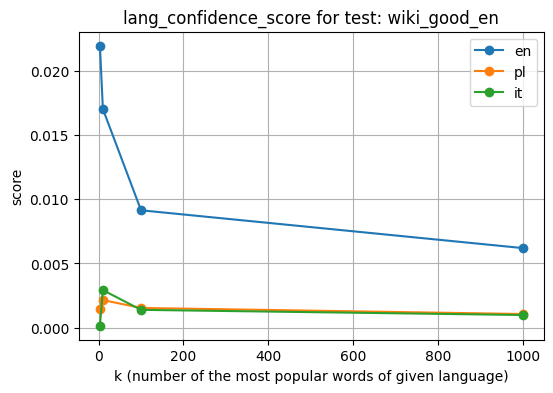

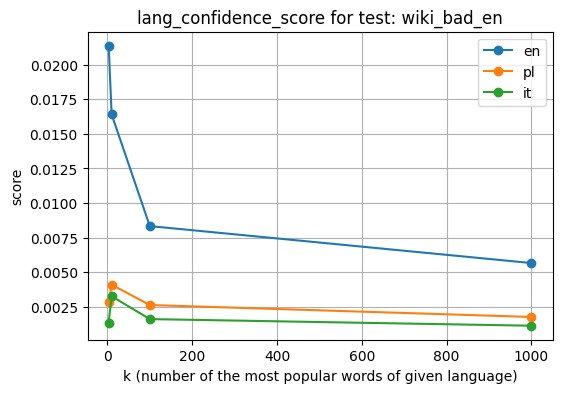

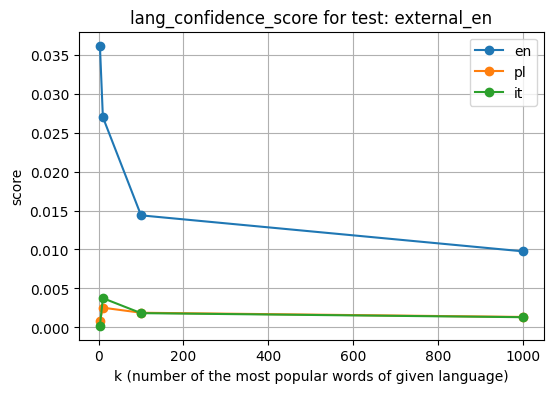

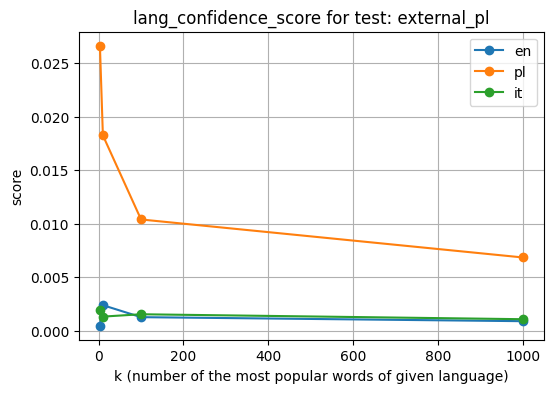

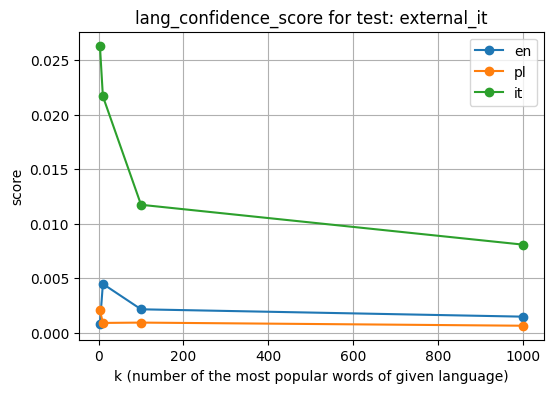

In [8]:
for text_name in texts.keys():
    subset = results_df[results_df["text"] == text_name]

    plt.figure(figsize=(6, 4))
    for lang_code in languages.keys():
        sub2 = subset[subset["language"] == lang_code]
        plt.plot(sub2["k"], sub2["score"], marker='o', label=lang_code)

    plt.title(f"lang_confidence_score for test: {text_name}")
    plt.xlabel("k (number of the most popular words of given language)")
    plt.ylabel("score")
    plt.legend()
    plt.grid(True)
    plt.show()

# Czy dobór języków miał duże znaczenie?

Z pewnością. Wybrane języki (polski, angielski, włoski) są dość dalekie od siebie, dlatego na wykresach widać wyraźnie, jaki język jest najbardziej prawdopodobny.

Jeśli wybranoby języki podobne (np. szwedzki, norweski i duński) to dopasowanie tekstu do języków byłoby znacznie mniej zróznicowane.

# Czy po wartościach language_words_with_frequency dla danych i najczęstszych słowach z języka danych widać, że w wybranym języku słowa często są odmieniane?

Tak, zwłaszcza w języku polskim (i trochę włoskim). Popularne słowa wcale nie muszą wpływać na wynik funkcji, poniewaz mogą mieć nietypową odmianę, która sama w sobie nie jest juz tak popularna.
Przykład: polskie słowo ,,dzieci" z pewnością jest popularne, jednak ,,dziećmi" juz niekoniecznie.

# Czy trudne było znalezienie takiego artykułu, dla którego wynik language_words_with_frequency jest jak najmniejszy w języku wiki? Czy to specyfika tego wiki?

Znalezienie takiego artykułu było bardzo trudne. Mimo, ze kazdy artykuł bulbapedii jest wypełniony nazwami własnymi, to takze kazdy zawierał bardzo popularne angielskie słowa. Ponadto, okazało się, ze stosunek nazw własnych do słów angielskich jest podobny dla kazdego artykułu, z kolei słowa angielskie mają taki sam rozkład ,,popularności". Dlatego wyniki nie są zróznicowane.